In [1]:
import os, glob, cv2, numpy as np, matplotlib.pyplot as plt, matplotlib.image as mpimg, pandas as pd, math, statistics, scipy
from sklearn.ensemble import IsolationForest
from PIL import Image
from scipy import ndimage, stats
from matplotlib import rcParams

# base directory should contain 1 or more matched "pairs" of images suitable for calibration
# ideal imagery for calibration includes near-sea level land at the interior margin

base_dir = r"D:\Example_datasets\Waldo_datasets\unspecific_pairs\8_03_22-uncropped"
# the file extension of the imagery. We could code a different way to read in images, but this works.
img_ext = "jpg"

img_list = glob.glob(f"{base_dir}//*.jpg", recursive=True)

# identify all file pairs with the same name aside from the first character
pair_list = np.unique([i.split("\\")[-1][1:] for i in img_list], return_counts=True)
pair_list = pair_list[0][pair_list[1]==2]
# this variable sets left vs. right prefixes for the image files
prefixes = {'right':0, 'left':1}
pairs = [{k: f"{base_dir}\\{v}{i}" for k, v in prefixes.items()} for i in pair_list]

# change the index number ("0") to change the pair
trgt_pair = pairs[0]
print(trgt_pair)

{'right': 'D:\\Example_datasets\\Waldo_datasets\\unspecific_pairs\\8_03_22-uncropped\\0_000_00_112.jpg', 'left': 'D:\\Example_datasets\\Waldo_datasets\\unspecific_pairs\\8_03_22-uncropped\\1_000_00_112.jpg'}


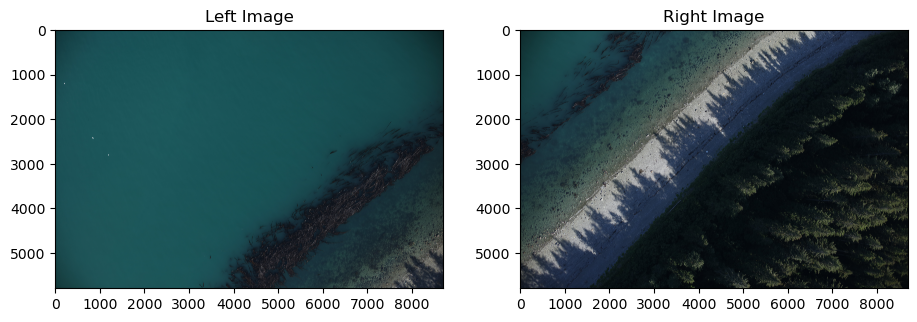

In [2]:
# this section reads in the images and displays them
img_l = mpimg.imread(trgt_pair["left"])
img_r = ndimage.rotate(mpimg.imread(trgt_pair["right"]), 180)

im_height, im_width, im_channels = img_l.shape

def display_image_pair(left_image, right_image):
    rcParams['figure.figsize'] = 11 ,8
    fig, ax = plt.subplots(1,2)
    
    ax[0].imshow(left_image)
    ax[1].imshow(right_image)
    ax[0].set_title("Left Image")
    ax[1].set_title("Right Image")

display_image_pair(img_l, img_r)

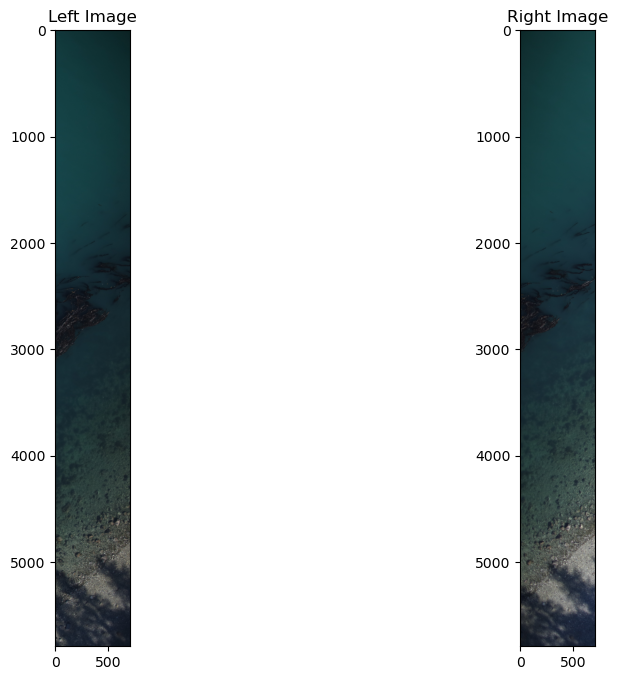

In [3]:
# this section crops the images to just the inner margin where we expect overlap
# to reduce the number of spurious tie points possible
inner_margin = 700
img1 = img_l[0:im_height, im_width-inner_margin:im_width]
img2 = img_r[0:im_height, 0:inner_margin]
display_image_pair(img1, img2)

In [4]:
# # Initialize ORB detector
#orb = cv2.ORB_create(1000000)

# Initiate SIFT detector
sift = cv2.SIFT_create(1000000)

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# Use BFMatcher to find matches
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(des1, des2)

In [5]:
# This section processes the matched tiepoints for handling

# Sort matches by distance
matches = sorted(matches, key=lambda x: x.distance)

des1 = des1.astype(np.float32)
des2 = des2.astype(np.float32)

def trigbearing(p1, p2):
    return (math.degrees(math.atan2(p2[1]-p1[1], p2[0]-p1[0])) + 360) % 360

def slope(p1, p2):
    if p2[0] == p1[0]:
        return 0
    else: return (p2[1]-p1[1])/(p2[0]-p1[0])
        
# Create dataframe with distance and slope between points
df = pd.DataFrame([[mat, kp1[mat.queryIdx], kp1[mat.queryIdx].pt, kp2[mat.trainIdx], kp2[mat.trainIdx].pt] for mat in matches], columns=['matches', 'kp1', 'kp1_pt','kp2', 'kp2_pt'])
df['kp1_pt_orig_x'] = [i[0]+im_width-(inner_margin+1) for i in df['kp1_pt']]
df['kp2_pt_orig_x'] = [i[0] for i in df['kp2_pt']]
df['kp1_pt_orig_y'] = [i[0] for i in df['kp1_pt']]
df['kp2_pt_orig_y'] = [i[0] for i in df['kp2_pt']]
df['distance'] = [math.dist(i.kp1_pt, i.kp2_pt) for i in df.itertuples()]
df["sin_bearing"] = [math.sin(trigbearing(i.kp1_pt, i.kp2_pt)) for i in df.itertuples()]
df["cos_bearing"] = [math.cos(trigbearing(i.kp1_pt, i.kp2_pt)) for i in df.itertuples()]

In [11]:
# This section proposes high-quality matches
# using an outlier removal algorithm called IsolationForest
# https://www.digitalocean.com/community/tutorials/anomaly-detection-isolation-forest

clf = IsolationForest(contamination=float(0.5)).fit(df[['distance', 'sin_bearing', 'cos_bearing']])
df['scores']=clf.decision_function(df[['distance', 'sin_bearing', 'cos_bearing']])
df_cluster = df.loc[df['scores']>=0,].copy()
df_anomaly = df.loc[df['scores']< 0,].copy()

In [12]:
### this code is for generating nearest high-quality neighbors around each point
### so we can look at the "constellation" of matched keypoints around them
### and see how much the constellation of keypoints at one end
### differs from the constellation on the other end, based on nearest-neighbor distances

# This function reads in 2 datasets of matches: a full dataset, and a subset of high quality matches
def median_nn_differences_two_datasets(df, df_cluster):

    # create an array of keypoint1 locations from all matches
    x = [np.array(i) for i in df['kp1_pt']]
    # create an array of keypoint1 locations from only high-quality matches
    y = [np.array(i) for i in df_cluster['kp1_pt']]
    # generate nearest neighbors tree for HQ points
    tree =scipy.spatial.KDTree(y)    
    # find nearest HQ neighbors for all points
    ordered_neighbors = tree.query(x, 11)
    
    # pull in an array of keypoint2 locations from all matches
    x_kp2s = [np.array(i) for i in df['kp2_pt']]
    # pull in an array of the original "index" values, used to call HQ matches
    y_idxs = np.array(df_cluster.reset_index()['index'])
    # replace the "nearest neighbor" table with original index values for complete dataframe
    orig_indices = np.array([[int(y_idxs[j]) for j in i] for i in ordered_neighbors[1]])
    # NN algorithms will include the "self" point if it's present as a closest neighbor
    # this line of code removes the "self" point, if present
    orig_indices = [np.delete(i, np.where(i == n))[0:10] for n, i in enumerate(orig_indices)]
    # convert the index lists to KP1 and KP2 point locations
    kp1_array = [[df.loc[j, 'kp1_pt'] for j in i] for i in orig_indices]
    kp2_array = [[df.loc[j, 'kp2_pt'] for j in i] for i in orig_indices]
    # calculate distances between reference points and their neighbors
    kp1_nn_distances = [[math.dist(x[n], j) for j in i] for n, i in enumerate(kp1_array)]
    kp2_nn_distances = [[math.dist(x_kp2s[n], j) for j in i] for n, i in enumerate(kp2_array)]
    # get the difference of these distances as aggregate metric of "constellation similarity"
    # then take median, to see if a point is overall consistent in its constellation or not
    median_kp1_kp2_distance_diff = np.median(np.array(kp1_nn_distances) - np.array(kp2_nn_distances), axis=1)
    return median_kp1_kp2_distance_diff

df['constellation_similarity'] = median_nn_differences_two_datasets(df, df_cluster)

In [13]:
# filtering primarily based on constellation similarity
constellation_threshold = 10

# leaving this code in, in case we ever want to try distance thresholding
# distance_percentile = 1
# distance_percentile = (0.5*(1-distance_percentile), (distance_percentile-(0.5*(1-distance_percentile))))

df_cluster =  df[abs(df['constellation_similarity']) < constellation_threshold \

                #& df[(df['distance'].between(df['distance'].quantile(distance_percentile[0]), df['distance'].quantile(distance_percentile[1]))) \
                ].copy()

# one more round of light filtering after selecting for constellation similarity
clf = IsolationForest(contamination=float(0.005)).fit(df_cluster[['distance', 'sin_bearing', 'cos_bearing', 'constellation_similarity']])
df_cluster['scores']=clf.decision_function(df_cluster[['distance', 'sin_bearing', 'cos_bearing', 'constellation_similarity']])
df_cluster = df_cluster.loc[df['scores']>=0,].copy()
df_anomaly = df_cluster.loc[df['scores']< 0,].copy()

In [15]:
# this section displays the matches on the cropped imagery.
# Press Q key to close the window and proceed when finished.

display_matches = True
if display_matches == True:
    img_matches = cv2.drawMatches(
        img1, kp1, img2, kp2, list(df_cluster.matches), None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    cv2.namedWindow('matches', cv2.WINDOW_NORMAL)
    cv2.imshow("matches", img_matches)
    wait_time = 1000
    while cv2.getWindowProperty('matches', cv2.WND_PROP_VISIBLE) >= 1:
        keyCode = cv2.waitKey(wait_time)
        if (keyCode & 0xFF) == ord("q"):
            cv2.destroyAllWindows()
            break

In [10]:
# This section looks at the horizontal displacement of features
# and calculates their distance to the edge of the image to determine
# the total size of the overlap zone

df['kp1_pt_orig_x'] = [i[0]+im_width-(inner_margin+1) for i in df['kp1_pt']]
df['kp2_pt_orig_x'] = [i[0] for i in df['kp2_pt']]
df['kp1_pt_orig_y'] = [i[0] for i in df['kp1_pt']]
df['kp2_pt_orig_y'] = [i[0] for i in df['kp2_pt']]
vertical_displacement = df['kp2_pt_orig_y']-df['kp1_pt_orig_y']
df = df.sort_values('kp1_pt_orig_x', ascending=False)
edge_of_im1_on_im2 = margin_r = statistics.median([i.kp2_pt_orig_x + (im_width-i.kp1_pt_orig_x) for i in df.itertuples()][0:int(len(df)/20)])
df = df.sort_values('kp2_pt_orig_x', ascending=True)
edge_of_im2_on_im1 = statistics.median([i.kp1_pt_orig_x - i.kp2_pt_orig_x for i in df.itertuples()][0:int(len(df)/20)])
margin_l = im_width - edge_of_im2_on_im1
mean_margin = statistics.mean([margin_l, margin_r])

# this bit just digests and presents key metrics of overlap

print(f"Average vertical displacement of {round(statistics.mean(vertical_displacement), 2)} pixels from left image to right")
print(f"Average of {round(mean_margin, 2)} pixels of horizontal overlap")
dead_center = mean_margin/2
print(f"Crop at least {math.ceil(dead_center)} pixels to eliminate overlap")
percent_overlap = mean_margin/im_width
print(f"{round(percent_overlap, 4)}% of each image overlaps its partner")
waldo_aovw = 39.597752709049864
angle_of_overlap = percent_overlap * waldo_aovw
print(f"Fields of view extend {round(angle_of_overlap, 2)}° past nadir")
waldo_angle = waldo_aovw - angle_of_overlap
print(f"Waldos were mounted {round(waldo_angle, 2)}° apart")

Average vertical displacement of -13.69 pixels from left image to right
Average of 569.88 pixels of horizontal overlap
Crop at least 285 pixels to eliminate overlap
0.0656% of each image overlaps its partner
Fields of view extend 2.6° past nadir
Waldos were mounted 37.0° apart
